# Deployment
### Charge predictions on graphs
<hr>
<code>
 // ===============================
 // AUTHOR     : Ali Raza
 // CREATE DATE     : Feb 15, 2020
 // PURPOSE     : charge predictions on graphs 
 // SPECIAL NOTES: needs models.pt (contains models trained for gaussian and mean correction)
 // ===============================
 // Change History: 0.1: initial code: wrote and tested.
 // Change History: 0.2: updated code: used torch.long to increae accuracy 
// Change History:  0.3: Added argument parser 
 //
 //==================================
</code>


### Libraries

In [4]:

__author__ = "Ali Raza"
__copyright__ = "Copyright 2020"
__credits__ = []
__license__ = ""
__version__ = "2.0"
__maintainer__ = "ali raza"
__email__ = "razaa@oregonstate.edu"
__status__ = "done"

from data_handling import *
from model import *
# from charge_prediction_system_L1_embedding import *
from torch_geometric.data import Data, DataLoader
import torch
import os
import numpy as np
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import math
from random import shuffle
import copy
import pandas as pd
import seaborn as sns
import csv
import argparse


print('>>> Specifications')
print("Torch version: {}".format(torch.__version__))
print("Cuda Available: {}".format(torch.cuda.is_available()))
print("CuDNN Enabled: {}".format(torch.backends.cudnn.enabled))
print("Using ",torch.cuda.get_device_name(torch.cuda.current_device()))

>>> Specifications
Torch version: 1.3.1
Cuda Available: True
CuDNN Enabled: True
Using  GeForce GTX 1080


### Parameters 

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("graphs", help="string specifying the directory in ../building_graphs/ containing graphs")
args = parser.parse_args()

# deployment_graphs = "deployment_graphs_ASR"
# deployment_graphs = "deployment_graphs_FSR"
# deployment_graphs_location = "../build_graphs/" + deployment_graphs
# deployment_graphs = "../build_graphs/deployment_graphs_FSR"

deployment_graphs = args.graphs
deployment_graphs_location = "../build_graphs/" + deployment_graphs
print('>>> will search {} for graphs'.format(deployment_graphs_location))

systems = ['mean_cor', 'gaussian_cor']
device = torch.device('cuda')
crit = torch.nn.L1Loss()

# for graphs decorations
hfont = {'fontname':'Times New Roman'}
fontsize_label_legend = 24



### Reading graphs 

In [14]:
print("----------------------------------------------")
print(">>> reading files and generating data_list")
data_list = data_handling(deployment_graphs_location) #, READ_LABELS = False)
print("...done")
print("----------------------------------------------")
print()

# dividing data into testing and training
NUM_NODE_FEATURES = data_list[0]['x'].shape[1]
print("Total MOFs: {} ".format(len(data_list)))


----------------------------------------------
>>> reading files and generating data_list
Number of crystals:  9173
...done
----------------------------------------------

Total MOFs: 9173 


### Preparaing Data
generating summary in <code>results/graphs_directory</code>

Total MOFs: 9173
----------------------------------------------
>>>Getting encoding information
----------------------------------------------
Total nodes: 2589582


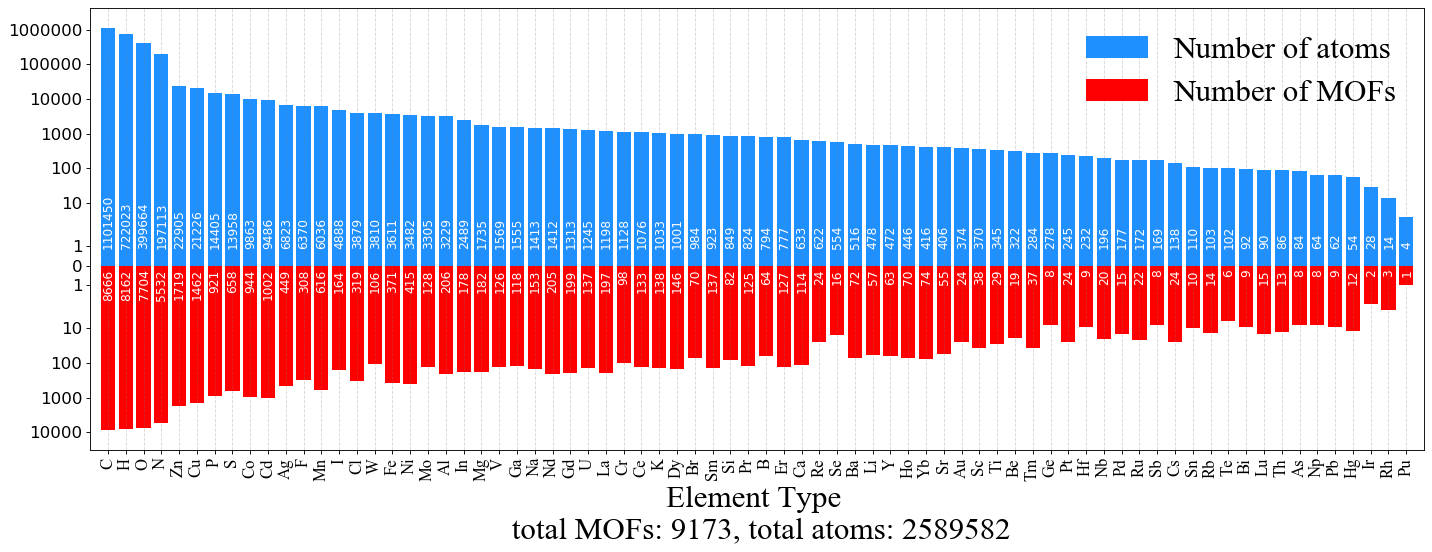

In [15]:
#-----------------------------------------------

dataa = data_list
loader = DataLoader(dataa, batch_size=len(dataa))

# creating directories 
if not(os.path.exists("results/")):
    os.mkdir('results/')
if not(os.path.exists("results/predictions")):
    os.mkdir('results/predictions')
    
print("Total MOFs: {}".format(len(dataa) ))
print("----------------------------------------------")
print(">>>Getting encoding information")
with open('../atom_to_int.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    element_types = []
    one_hot_encoding = []
    next(readCSV)
    for row in readCSV:
        element_types.append(row[0])
        one_hot_encoding.append(int(row[1]))

    # sorting them    
    indices_sorted_elements = np.argsort(one_hot_encoding)
    element_types = np.array(element_types)[indices_sorted_elements]
    one_hot_encoding = np.array(one_hot_encoding)[indices_sorted_elements]
print('... done')
print("----------------------------------------------")
for data in loader:
        data = data.to(device)
        features = data.x.to(device)
        
        print("Total nodes: {}".format(features.size()[0]))
#         print("Features.size(): {}".format(features.size()))
        
        elements_number = len(features[0])
        total_instances_all = np.zeros(elements_number)
        total_instances_mof_all = np.zeros(elements_number)
        mean_element_all = np.zeros(elements_number)
        min_element_all = np.zeros(elements_number)
        max_element_all = np.zeros(elements_number)
        
        total_atoms = 0
        
        for element_index in range(elements_number):
            indices = (features[:, element_index] == 1)
            total_atoms += indices.sum()
            total_instances_all[element_index] = indices.sum() # number of atoms in datasets
            total_instances_mof_all[element_index] = len(set(data.batch[indices].cpu().numpy())) # number of mofs containing that element

        
        # indices of sorted element
        
        indices_sorted_elements = np.argsort(total_instances_all)
        indices_sorted_elements=np.flipud(indices_sorted_elements)
        
#%-----------------------------------------------------------------------        
        
        fig = plt.figure(figsize=(18, 7), dpi= 80) # Create matplotlib figure
        ax = fig.add_subplot(111) # Create matplotlib axes
        ax.bar(np.arange(elements_number), total_instances_all[indices_sorted_elements], label='Number of atoms', color= 'dodgerblue')
        ax.bar(np.arange(elements_number), -1*(total_instances_mof_all[indices_sorted_elements]), label='Number of MOFs', color='red')        
        plt.tick_params(axis='both', which='major', labelsize=16)
        # Formatting x labels
        plt.xlabel("Element Type \n total MOFs: {}, total atoms: {}".format(len(data_list),total_atoms ), fontsize=28, **hfont)
        ax.set_xticks(np.arange(elements_number))
        element_types2 = np.array(element_types)[indices_sorted_elements]
        ax.set_xticklabels(element_types2,  size=15, **hfont)
        plt.xticks(rotation=90)
        
        ax.set_yscale('symlog')
        # Use absolute value for y-ticks
        ticks =  ax.get_yticks()
        ax.set_yticklabels([int(abs(tick)) for tick in ticks])
        for index, data in enumerate((total_instances_all[indices_sorted_elements].astype(int))):
            plt.text(x=index+0.03, y= 1, s=f"{data}", fontdict=dict(fontsize=11), rotation='vertical', color='white', ha='center')
        for index, data in enumerate((total_instances_mof_all[indices_sorted_elements].astype(int))):
            plt.text(x=index+0.03, y= -0.2, s=f"{data}", fontdict=dict(fontsize=11), rotation='vertical', color='white', va='top', ha='center')
        plt.legend(frameon=False, prop={"family":"Times New Roman", 'size': 28})
        plt.xlim([-1,74])
        plt.gca().xaxis.grid(True,color='gray', linestyle='--', alpha=0.3, zorder=0)
        plt.tick_params(axis='both', which='major', labelsize=15)
        plt.tight_layout()
        plt.savefig('results/'+deployment_graphs+'_dataset_element_distribution.png', format='png', dpi=300, bbox_inches="tight")
        plt.show()
#%-----------------------------------------------------------------------        
 


### Loading models

In [16]:
models = torch.load('./models_deployment.pt')

### Predicting charges
placing them in <code>results/predictions/graphs_location</code>

In [17]:
if not(os.path.exists("results/predictions/"+deployment_graphs)):
    os.mkdir('results/predictions/'+deployment_graphs)

dataa = data_list
loader = DataLoader(dataa, batch_size=1)
print("Total MOFs: {}".format(len(dataa) ))
crystals_names = np.load("crystals_name.npy")

print()
print()

with torch.no_grad():
    index_mof = 0
    for data in loader:
        data = data.to(device)       
        data.x = data.x.type(torch.DoubleTensor).to(device)      
        features = data.x.to(device)
    
        
        for index, system in enumerate(systems):
            model = models[index]
            model.eval()
            pred, embedding, sigmas, uncorrected_mu = model(data)
            np.save("results/predictions/{}/{}_{}_predictions".format(deployment_graphs, crystals_names[index_mof], system), pred.cpu().numpy())
        index_mof += 1
        if index_mof % 100 == 0:
            print('||| Done with MOFs: {}'.format(index_mof), end="\r", flush=True)
print('||| Done with MOFs: {}'.format(index_mof), end="\r", flush=True)



Total MOFs: 9173


max: sum_charge:  [1.4560253e-10]
min: sum_charge:  [-1.745315e-10]


<hr> 

### Code for debugging


In [ ]:


# if not(os.path.exists("results/predictions/"+deployment_graphs)):
#     os.mkdir('results/predictions/'+deployment_graphs)

# dataa = data_list
# loader = DataLoader(dataa, batch_size=1)
# print("Total MOFs: {}".format(len(dataa) ))
# crystals_names = np.load("crystals_name.npy")

# print()
# print()
# sum_charge_all = []
# graphs_nodes = []
# graphs_nodes_high_sum = []
# graphs_nodes_low_sum = []
# with torch.no_grad():
#     index_mof = 0
#     for data in loader:
#         data = data.to(device)       
#         data.x = data.x.type(torch.DoubleTensor).to(device)      
#         features = data.x.to(device)
    
        
#         for index, system in enumerate(systems):
#             model = models[index]
#             model.eval()
#             pred, embedding, sigmas, uncorrected_mu = model(data)
#             #-------- debugging
# #             pred = uncorrected_mu - np.mean(uncorrected_mu.cpu().numpy()) # only mof with 10560 nodes gets sum 0.0014
# #             pred = uncorrected_mu - torch.mean(uncorrected_mu)  # only one mof with 2924 nodes get sum 0.0018
# #             pred = uncorrected_mu - torch.sum(uncorrected_mu)*(sigmas/torch.sum(sigmas)) # three mofs with 10560 nodes(why same??) gets high sum0.0022
# #             # now
# #             mu_all = ts.scatter_add(uncorrected_mu, data.batch, dim=0)
# #             sigma_all = ts.scatter_add(sigmas, data.batch, dim=0)

# #             for i in range(0, data.num_graphs):
# #                 uncorrected_mu[data.batch == i] = uncorrected_mu[data.batch == i] - mu_all[i] * (sigmas[data.batch == i] / sigma_all[i])
# #             pred = uncorrected_mu
# #             pred = pred.type(torch.DoubleTensor)
# #             pred = pred.cuda()
#             sum_charge =   ts.scatter_add(pred, data.batch, dim=0)
#             sum_charge_all.append( sum_charge.cpu().numpy() ) 
# #             sum_charge = np.sum(pred.cpu().numpy())
# #             sum_charge_all.append( np.absolute(sum_charge) )
#             graphs_nodes.append(len(pred))
#             if np.absolute(sum_charge.cpu()) > 0.001:
# #                 np.save('uncorrected_mu.npy',uncorrected_mu.cpu().numpy() )
#                 print('nodes in MOF with high sum charge {}: '.format(np.absolute(sum_charge.cpu())), len(pred))
#                 graphs_nodes_high_sum.append(len(pred))
#             if np.absolute(sum_charge.cpu()) < 0.000001:
#                 graphs_nodes_low_sum.append(len(pred))
#             #-----------------
            
# #             plt.figure(figsize=(8,8), dpi= 80)
# #             plt.hist(sum_charge.cpu(), bins=10)
# #             plt.show()
# #             for i in (np.absolute(sum_charge.cpu()).sort()[0]):
# #                 print('{}'.format(i ))
#             np.save("results/predictions/{}/{}_{}_predictions".format(deployment_graphs, crystals_names[index_mof], system), pred.cpu().numpy())
#         index_mof += 1
#         if index_mof % 100 == 0:
#             print('||| Done with MOFs: {}'.format(index_mof), end="\r", flush=True)
# print('||| Done with MOFs: {}'.format(index_mof), end="\r", flush=True)

# print('max: sum_charge: ', max(sum_charge_all) )
# print('min: sum_charge: ', min(sum_charge_all) )


# plt.figure(figsize=(8,8), dpi= 80)
# plt.hist(np.array(sum_charge_all))
# plt.show()

# plt.figure(figsize=(8,8), dpi= 80)
# plt.hist(graphs_nodes, bins=20)
# plt.show()

# plt.figure(figsize=(8,8), dpi= 80)
# plt.hist(graphs_nodes_high_sum, bins=20)
# plt.show()

# plt.figure(figsize=(8,8), dpi= 80)
# plt.hist(graphs_nodes_low_sum, bins=20)
# plt.show()